In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.io
from sklearn.neighbors import KernelDensity
# plt.style.use('fast')

In [2]:
# Load data
path_pd = 'data/jags_output/pc_factorial_run1_pd_only.mat'
path_pi = 'data/jags_output/pc_factorial_run1_pi_only.mat'
path_pmp = 'data/vba_input/pmp_seq.mat'

n_subjects = 32
n_conditions = 2
n_prederrsign = 2
n_chains = 4
n_samples = 4000
sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]

mat = scipy.io.loadmat(path_pd, variable_names=['samples'], squeeze_me=True)
alpha_pd = mat['samples']['alpha_pd'].item()
mat = scipy.io.loadmat(path_pi, variable_names=['samples'], squeeze_me=True)
alpha_pi = mat['samples']['alpha_pi'].item()
mat = scipy.io.loadmat(path_pmp, variable_names=['pmp_seq'], squeeze_me=True)
pmp_main = mat['pmp_seq']
pd_prob = pmp_main[1, :] / (n_chains * n_samples)

## Point parameter estimation
Estimate learning rate values as point estimates of posterior probability distribution. First, MCMC samples are converted into continuous function using kernel density estimation (KDE) with Gaussian kernel. Then, argument maximizing estimated distribution is considered as point estimate of $\alpha$. Paramater `n_gridpoints` control the grid sparsity over parameter space (i.e. gridpoints for which KDE distribution is estimated). Smoothing of KDE distribution is adjusted by `kernel_width` parameter.

### PICD Model
Simpler model assuming two separate learning rates for reward / punishment task conditions. Learning is independent of choice made in the previous trial.

In [3]:
n_gridpoints = 101
kernel_width = 0.01

gridpoints = np.linspace(0, 1, n_gridpoints)
alpha_pi_mle = np.zeros((n_subjects, 2)) # point parameter estimation 

for sub in range(n_subjects):
    
    # calculate parameters as maximum likelihood
    kde = KernelDensity(bandwidth=kernel_width, kernel='gaussian')
    
    for j in range(n_conditions):
        
            kde.fit(alpha_pi[:, :, sub, j].flatten()[:, np.newaxis])
            alpha_pi_mle[sub, j] = \
                gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]

Plot posterior distributions for $\alpha^{PI}_{rew}$ and $\alpha^{PI}_{pun}$.

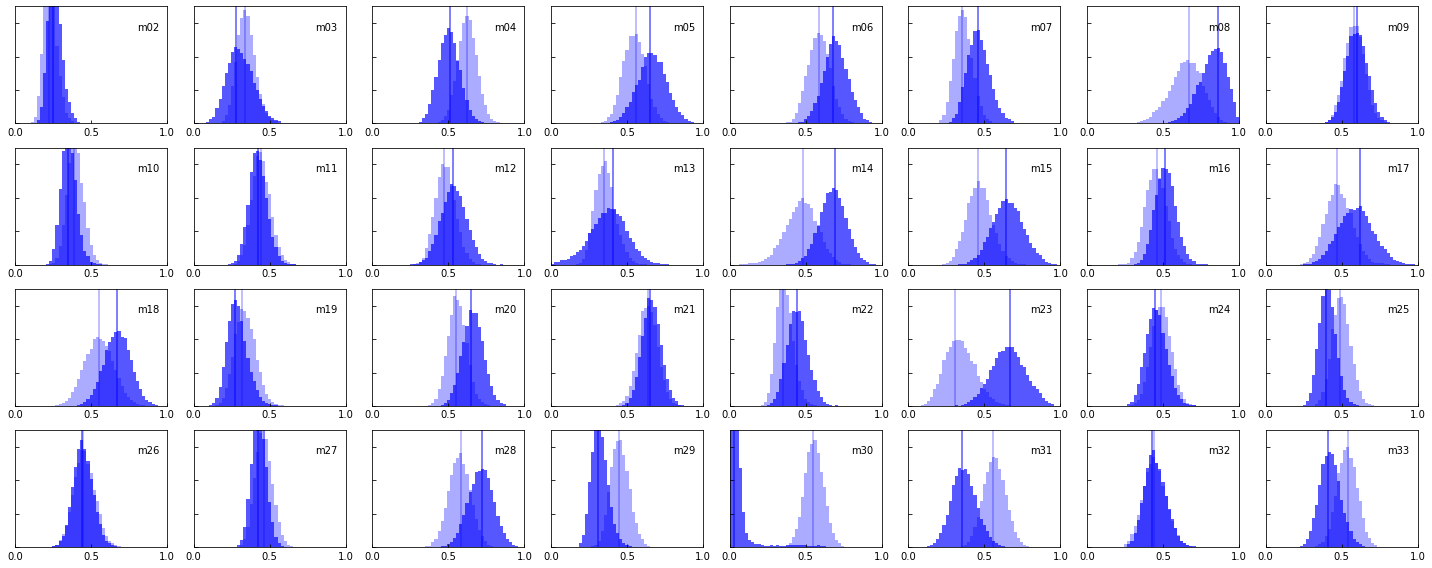

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=8, facecolor='w', figsize=(20, 8))

n_bins = 50
bins = np.linspace(0, 1, n_bins)

for sub in range(n_subjects):
    
    i, j = sub // 8, sub % 8
    
    # reward condition
    ax[i,j].hist(alpha_pi[:, :, sub, 0].flatten(), bins,
                 density=True, color='blue', alpha=.33, stacked=True)
    ax[i,j].axvline(alpha_pi_mle[sub, 0], color='blue', alpha=.33)
    # punishment condition
    ax[i,j].hist(alpha_pi[:, :, sub, 1].flatten(), bins,
                 density=True, color='blue', alpha=.66, stacked=True)
    ax[i,j].axvline(alpha_pi_mle[sub, 1], color='blue', alpha=.66)
        
    ax[i,j].set_xlim([0, 1])
    ax[i,j].set_xticks([0, 0.5, 1])
    ax[i,j].set_ylim([0, 7])              
    ax[i,j].set_yticklabels([])
    ax[i,j].tick_params(direction='in')
    
for sub, axes in enumerate(ax.flatten()):
    
    axes.annotate(sublabels[sub], xy=(.8, .8),
                  xycoords='axes fraction', size=10)

plt.tight_layout()
fig.savefig('pygures/posterior_alpha_pi_all.png')

Show subjects in parameter space

/home/kmb/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


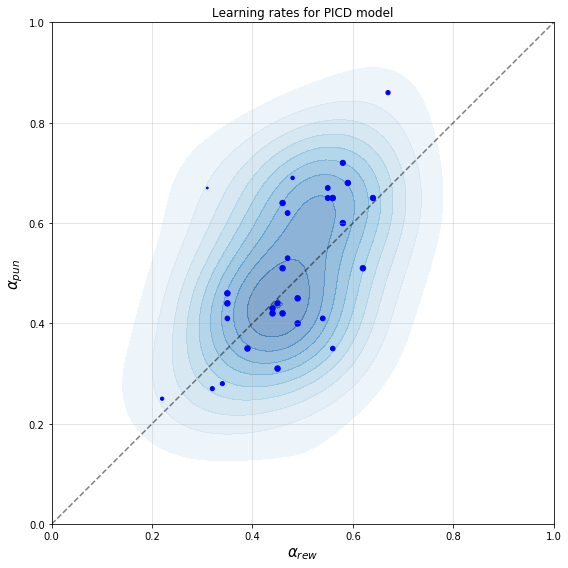

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(8, 8))

ax.plot([0, 1], [0, 1], 'k--', alpha=.5)
sns.kdeplot(
    alpha_pi_mle[:, 0],
    alpha_pi_mle[:, 1],
    cmap="Blues", 
    shade=True, 
    shade_lowest=False, 
    ax=ax,
    alpha=.5,
    bw=.1
)
ax.scatter(
    alpha_pi_mle[:, 0], 
    alpha_pi_mle[:, 1], 
    s=(1-pd_prob) * 30, # Amount of evidence in favor of PI model (% of z samples)
    color='b', 
)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(alpha=.4)
ax.set_title('Learning rates for PICD model')
ax.set_xlabel(r'$\alpha_{rew}$', fontsize=15)
ax.set_ylabel(r'$\alpha_{pun}$', fontsize=15)
plt.tight_layout()
fig.savefig('pygures/posterior_alpha_pi_correlations.png')

### PDCD Model
Most complex model that assumes four separate learning rates for positive / negative prediction errors and reward / punishment task conditions.

In [6]:
n_gridpoints = 101
kernel_width = 0.01

gridpoints = np.linspace(0, 1, n_gridpoints)
alpha_pd_mle = np.zeros((n_subjects, 2, 2)) # point parameter estimation 

for sub in range(n_subjects):
    
    # calculate parameters as maximum likelihood
    kde = KernelDensity(bandwidth=kernel_width, kernel='gaussian')
    
    for j in range(n_conditions):
        
        for k in range(n_prederrsign):
        
            kde.fit(alpha_pd[:, :, sub, j, k].flatten()[:, np.newaxis])
            alpha_pd_mle[sub, j, k] = \
                gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]

Plot posterior distributions for $\alpha^{+}_{rew}$, $\alpha^{+}_{pun}$, $\alpha^{-}_{rew}$ and $\alpha^{-}_{pun}$.

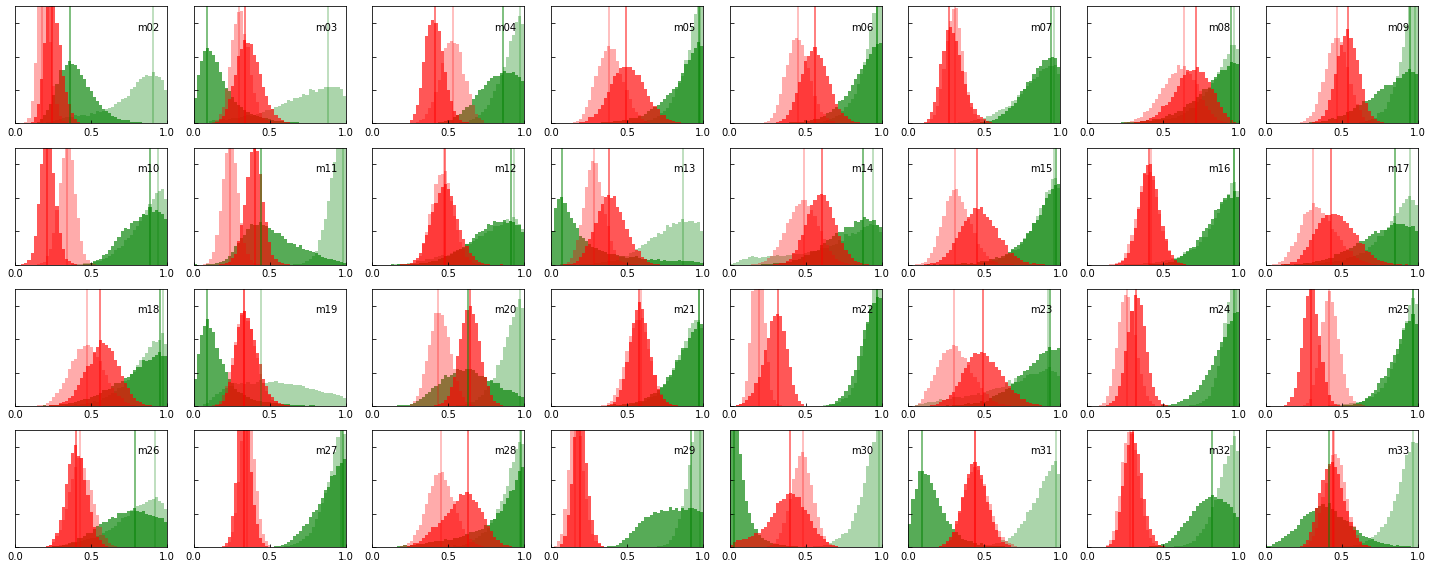

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=8, facecolor='w', figsize=(20, 8))

n_bins = 50
bins = np.linspace(0, 1, n_bins)

for sub in range(n_subjects):
    
    i, j = sub // 8, sub % 8
    
    # Positive PE (reward condition)
    ax[i,j].hist(alpha_pd[:, :, sub, 0, 0].flatten(), bins,
                 density=True, color='green', alpha=.33, stacked=True)
    ax[i,j].axvline(alpha_pd_mle[sub, 0, 0], color='green', alpha=.33)
    # Positive PE (punishment condition)
    ax[i,j].hist(alpha_pd[:, :, sub, 1, 0].flatten(), bins,
                 density=True, color='green', alpha=.66, stacked=True)
    ax[i,j].axvline(alpha_pd_mle[sub, 1, 0], color='green', alpha=.66)
    # Negative PE (reward condition)
    ax[i,j].hist(alpha_pd[:, :, sub, 0, 1].flatten(), bins,
                 density=True, color='red', alpha=.33, stacked=True)
    ax[i,j].axvline(alpha_pd_mle[sub, 0, 1], color='red', alpha=.33)
    # Negative PE (punishment condition)
    ax[i,j].hist(alpha_pd[:, :, sub, 1, 1].flatten(), bins,
                 density=True, color='red', alpha=.66, stacked=True)
    ax[i,j].axvline(alpha_pd_mle[sub, 1, 1], color='red', alpha=.66)
        
    ax[i,j].set_xlim([0, 1])
    ax[i,j].set_xticks([0, 0.5, 1])
    ax[i,j].set_ylim([0, 7])              
    ax[i,j].set_yticklabels([])
    ax[i,j].tick_params(direction='in')
    
for sub, axes in enumerate(ax.flatten()):
    
    axes.annotate(sublabels[sub], xy=(.8, .8),
                  xycoords='axes fraction', size=10)

plt.tight_layout()
fig.savefig('pygures/posterior_alpha_pd_all.png')

Show subjects in parameter space. 

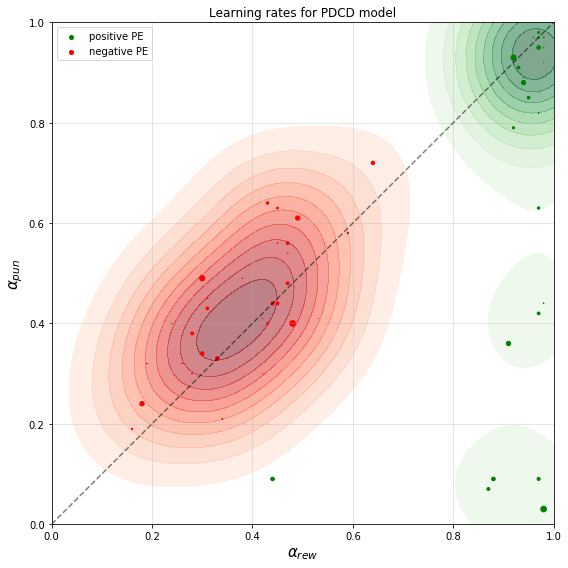

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(8, 8))

ax.plot([0, 1], [0, 1], 'k--', alpha=.5)
sns.kdeplot(
    alpha_pd_mle[:, 0, 0],
    alpha_pd_mle[:, 1, 0],
    cmap="Greens", 
    shade=True, 
    shade_lowest=False, 
    ax=ax,
    alpha=.5,
    bw=.1
)
sns.kdeplot(
    alpha_pd_mle[:, 0, 1], 
    alpha_pd_mle[:, 1, 1], 
    cmap="Reds", 
    shade=True, 
    shade_lowest=False,
    ax=ax,
    alpha=.5,
    bw=.1
)
ax.scatter(
    alpha_pd_mle[:, 0, 0], 
    alpha_pd_mle[:, 1, 0], 
    s=pd_prob * 30, # Amount of evidence in favor of PD model (% of z samples)
    color='g', 
    label='positive PE'
)
ax.scatter(
    alpha_pd_mle[:, 0, 1], 
    alpha_pd_mle[:, 1, 1], 
    s=pd_prob * 30,
    color='r', 
    label='negative PE')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(alpha=.4)
ax.set_title('Learning rates for PDCD model')
ax.set_xlabel(r'$\alpha_{rew}$', fontsize=15)
ax.set_ylabel(r'$\alpha_{pun}$', fontsize=15)
ax.legend()
plt.tight_layout()
fig.savefig('pygures/posterior_alpha_pd_correlations.png')

In [9]:
# Save point estimates to file
np.save('data/subjects_point_estimates/alpha_pd_mle', alpha_pd_mle)

### PDCI model (from sequential HM)
This model assumes separate learning rates for positive / negative prediction errors and learning rate invariance in respect to task condition. It is a part of sequential HM, and was evaluated separately, after establishing that this is the most likely model of participants response.

In [10]:
# Load data
path_picd = 'data/jags_output/pdci_run1.mat'
path_pmp_seq = 'data/vba_input/pmp_seq.mat'

mat = scipy.io.loadmat(path_picd, variable_names=['samples', 'nSamples'], 
                       squeeze_me=True)
alpha_pdci = mat['samples']['alpha_pdci'].item()

n_subjects = 32
n_conditions = 2
n_prederrsign = 2
n_chains = 4
n_samples = mat['nSamples']
sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]

mat = scipy.io.loadmat(path_pmp_seq, variable_names=['pmp_seq'], squeeze_me=True)
pmp_seq = mat['pmp_seq']
pdci_prob = pmp_seq[2, :] / (n_chains * 7500) # Posterior for pdci model 

In [11]:
n_gridpoints = 101
kernel_width = 0.01

gridpoints = np.linspace(0, 1, n_gridpoints)
alpha_pdci_mle = np.zeros((n_subjects, 2)) # point parameter estimation 

for sub in range(n_subjects):
    
    # calculate parameters as maximum likelihood
    kde = KernelDensity(bandwidth=kernel_width, kernel='gaussian')
    
    for j in range(n_prederrsign):
        
            kde.fit(alpha_pdci[:, :, sub, j].flatten()[:, np.newaxis])
            alpha_pdci_mle[sub, j] = \
                gridpoints[np.argmax(kde.score_samples(gridpoints[:, np.newaxis]))]

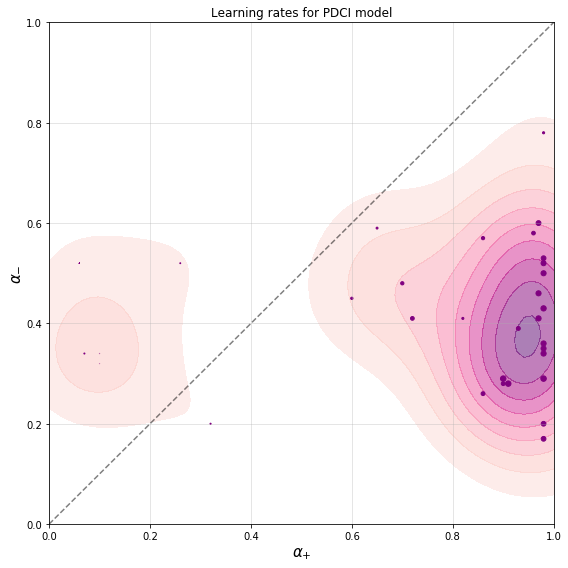

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(8, 8))

ax.plot([0, 1], [0, 1], 'k--', alpha=.5)
sns.kdeplot(
    alpha_pdci_mle[:, 0],
    alpha_pdci_mle[:, 1],
    cmap="RdPu", 
    shade=True, 
    shade_lowest=False, 
    ax=ax,
    alpha=.5,
    bw=.1
)
ax.scatter(
    alpha_pdci_mle[:, 0], 
    alpha_pdci_mle[:, 1],
    s=pdci_prob*30,
    color='purple', 
)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(alpha=.4)
ax.set_title('Learning rates for PDCI model')
ax.set_xlabel(r'$\alpha_{+}$', fontsize=15)
ax.set_ylabel(r'$\alpha_{-}$', fontsize=15)
plt.tight_layout()

In [13]:
# Save point estimates to file
np.save('data/subjects_point_estimates/alpha_pdci_mle', alpha_pdci_mle)